# Description: This notebook explains how Universal Sentence Encoder is better than a TF-IDF Model
# Author Name: Anurag Karuparti

# 1. IMPORTING ALL NECESSARY LIBRARIES & DATA

In [1]:
import tensorflow_hub as hub
import tensorflow as tf
import os
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import functions
import data_utils
import modularity
from sklearn.externals import joblib
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS
from array import array
import nltk, re, string, collections
from nltk.util import ngrams

### EXTRACTING ~300K TITLES

In [2]:
submissions = pickle.load(open('/financial_wellness_chatbot/data/personalfinance_submissions.pickle', 'rb'))
vectorize_on = 'title_query'
if vectorize_on == 'title': data = [s.title for s in submissions]
elif vectorize_on == 'query': data = [s.selftext for s in submissions]
elif vectorize_on =='title_query':data= [(s.title, s.selftext) for s in submissions]

In [3]:
len(data)

297018

# 2. PASSING THE DATA THROUGH UNIVERSAL SENTENCE ENCODER

In [4]:
## activating the BATCHER FUNCTION
batcher = data_utils.DataBatcher(data, 1000)

In [5]:
##CALLING UNVERSAL SENTENCE ENCODER
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [6]:
##USING THE EMBED FUNCTION

def embed_func():
    """Encodes text into a 512 dimensional vector embedding"""
    
    graph = tf.Graph()
    
    with graph.as_default():
        embed = hub.Module(module_url)
        session = tf.Session()
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    
    def run_embed(text_list):
        with graph.as_default():
            message_embeddings = session.run(embed(text_list))
        return message_embeddings
    
    return run_embed

In [7]:
##SETTING UP ENVIRONMENT VARIABLES
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

tf.reset_default_graph()
with tf.device("/gpu:0"):
    get_embeddings = embed_func()

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/96e8f1d3d4d90ce86b2db128249eb8143a91db73/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/96e8f1d3d4d90ce86b2db128249eb8143a91db73/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/96e8f1d3d4d90ce86b2db128249eb8143a91db73/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/96e8f1d3d4d90ce86b2db128249eb8143a91db73/variables/variables' with Embeddings_en/sharded_11
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_12:0 from checkpoint b'/tmp/tfhub_modules/96e8f1d3d4d90ce86b2db128249eb8143a91db73/v

### Obtaining the data for training and clustering

In [9]:
##Using 10,000 samples of the dataset for clustering
vectorized_data = []
for _ in range(10):
    texts = batcher.next_batch()
    k = [d[0] for d in texts]
    vectors = get_embeddings(k)
    vectorized_data += list(zip(texts, vectors))

In [10]:
texts, vectors = zip(*vectorized_data)
array = np.array(vectors)

### Pickling the data for future purposes

In [11]:
## Dumping the vector in a pickle
##10,000
import pickle

file_Name = "USE_Vectors_Reddit_Titles_10k"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'USE_Vectors_Reddit_Titles_10k'
pickle.dump(vectorized_data,fileObject)  

# here we close the fileObject
fileObject.close()

In [12]:
##Loading the data into the vector
#fileObject = open(file_Name,'r')  

# load the object from the file into var b
vectorized_data_10k = joblib.load('USE_Vectors_Reddit_Titles_10k') 


### Using Variance analysis to find the optimal number of features for PCA

# 3. PERFORMING K-MEANS CLUSTERING TO OBTAIN CENTROIDS IN THE DATA

Text(0, 0.5, 'cumulative explained variance')

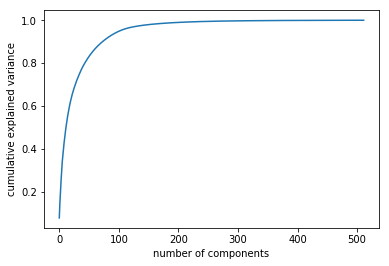

In [13]:
pca = PCA().fit(vectors)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

#for i,value in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    #print(i,value)
    
#When components=100, variance is 0.953
#reducing dimensions from 512 to 100

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(n_components=100)
pca.fit(vectors)
X_pca = pca.transform(vectors)
#print("original shape:   ", vectors.shape)
print("transformed shape:", X_pca.shape)

transformed shape: (10000, 100)


In [16]:
array_PCA = np.array(X_pca)

### KMeans Clustering

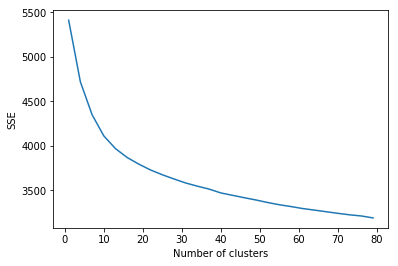

In [17]:
cluster_counts = range(1,80,3)
sse = {}
for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(array_PCA)
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(sorted(list(sse.keys())), sorted(list(sse.values()),reverse=True))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

## 50 clusters seems to be ideal because of the elbow

In [18]:
##50 clusters
kmeans = KMeans(n_clusters=50)
scores = kmeans.fit_transform(array_PCA)
clusters = np.argmin(scores, axis=1) #kmeans.labels_

In [36]:
##Obtaining titles from 10k dataset
titles=[i[0] for i in texts]

In [37]:
## 10,000 topics being assigned to nearest cluster

results_PCA = sorted(list(zip(titles, array_PCA, clusters)), key=lambda x: x[2])
centroids_PCA = {}
centroids1_PCA ={}
for i in set(clusters):
    filtered_results = [x for x in results_PCA if x[2] == i]
    v = np.array([x[1] for x in filtered_results])
    centroid_vector = np.mean(v, axis=0)
    arr5 = cosine_similarity(v, np.expand_dims(centroid_vector, axis=0))
    
    
    flat_list = [item for sublist in arr5 for item in sublist]
    arr6 = np.array(flat_list)
    
    x = arr6.argsort()[:][::-1]
    merged = list(itertools.chain(*arr5[x].tolist()))
    top = [filtered_results[i][0] for i in x.tolist()]
    
    closest = np.argmax(cosine_similarity(v, np.expand_dims(centroid_vector, axis=0)))   
    
    centroid_text_PCA = filtered_results[closest][0]
    centroid_text1_PCA = [filtered_results[i][0] for i in x.tolist()]
    centroids_PCA[i] = centroid_text_PCA
    centroids1_PCA[i] = centroid_text1_PCA


full_results_PCA = [(x[0], x[2], centroids_PCA[x[2]]) for x in results_PCA]

full_results1_PCA = [(x[0], x[2], centroids1_PCA[x[2]]) for x in results_PCA]

In [39]:
filtered_results[0]

('Recurring charges on a credit card a good way to build credit?',
 array([-0.27389804,  0.0997877 , -0.18711573,  0.23796724,  0.25611389,
         0.01492043, -0.04756873,  0.12865182,  0.11491567,  0.02026715,
         0.16946005, -0.16855923, -0.07575393, -0.04003848, -0.15298088,
         0.03256316,  0.02595029,  0.00712502,  0.01802214, -0.1183504 ,
         0.06136236, -0.02469423,  0.04911191,  0.06829851, -0.00539059,
        -0.00743161, -0.08561792, -0.0513623 ,  0.01821242, -0.01023535,
        -0.05436416, -0.00487805, -0.09925861, -0.05904886,  0.01302952,
        -0.01246029, -0.03604169, -0.02498457,  0.0171837 , -0.03469275,
         0.01141925,  0.00756048,  0.0518228 , -0.00387528, -0.02401937,
        -0.02177563,  0.04945109, -0.01899477, -0.00933796,  0.02580747,
         0.02151225, -0.01314174, -0.01909335, -0.00600699,  0.034835  ,
         0.02205577, -0.02466527,  0.02639822,  0.00796099,  0.06320342,
         0.03698962, -0.00783547,  0.0226243 , -0.0138847

In [40]:
#len(results[9][1])
#len(v)
filtered_results_PCA = [x for x in results_PCA if x[2] == 0]
len(filtered_results_PCA)

276

In [41]:
corpus=[]
for i in range(0,50):
    x=''
    for j in centroids1_PCA[i]:
        x= j+' '+x
    corpus.append(x)    

In [57]:
len(corpus)

50

In [46]:
##Corpus1 is the list of all titles ~300k in the dataset 
##Then perform a tfidf on the cluster and corpus1 to find important words

vectorizer1 = TfidfVectorizer(stop_words=stop_words)
tfidf1 = vectorizer1.fit(n.asarray(corpus))

### OBTAINING TESTING DATASET

In [137]:
len(unlabelled_data_pca)

1000

In [ ]:
##Obtaining the test data for title labeling to appropriate centroids
##We will use two methods
##Vectorize using tfidf
##Vectorize using USE
vectorized_data_full = []
for _ in range(300):
    texts_full = batcher.next_batch()
    k = [d[0] for d in texts_full]
    vectors_full= get_embeddings(k)
    vectorized_data_full += list(zip(texts_full,vectors_full))
unlabelled_data_pca = pca.transform(vectors_full)

In [48]:
unlabelled_data_pca = pca.transform(vectors_full)
#print("original shape:   ", vectors.shape)
#print("transformed shape:", unlabelled_data_pca.shape)

In [571]:
## Dumping the vector in a pickle

len(vectorized_full)

import pickle

file_Name = "USE_Vectors_Reddit_Titles"

# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
# file named 'testfile'
pickle.dump(vectorized_data_full,fileObject)   

# here we close the fileObject
fileObject.close()

In [572]:
##Loading the data into the vector

from sklearn.externals import joblib
#fileObject = open(file_Name,'r')  

# load the object from the file into var b
b = joblib.load('USE_Vectors_Reddit_Titles') 


len(b)

10000

In [49]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS

def get_important_words(num, tfidf, max_n=10):
    response = tfidf.transform([" ".join(centroids1_PCA[num])])
    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:max_n]
    return top_n

def get_frequent_words(num, max_n=10):
    stop_words = stopwords.words('english') + list(punctuation)
    text = [x for x in corpus[num].split() if x not in stop_words]
    counter = Counter(text)
    return list(zip(*sorted([(word, ct) for word, ct in counter.items()], key=lambda x: x[1], reverse=True)))[0][:max_n]


def top_titles_per_cluster(num,max_n=10):
    return list(centroids1_PCA[num][:max_n])


In [50]:
def ngram_func(num):
    str=''
    for i in centroids1_PCA[num]:
        str=str+i
    # first get individual words
    tokenized = str.split()

    # and get a list of all the bi-grams
    enBigrams = ngrams(tokenized, 2)

    # get the frequency of each bigram in our corpus
    enBigramFreq = collections.Counter(enBigrams)
    
    # and get a list of all the bi-grams
    enTrigrams = ngrams(tokenized, 3)

    # get the frequency of each bigram in our corpus
    enTrigramFreq = collections.Counter(enTrigrams)
    
    ## get the most common bigrams
    return enBigramFreq.most_common(15),2*'\n',enTrigramFreq.most_common(15)


In [57]:
k=3


print('Important Words')
print(get_important_words(k,tfidf1),'\n')


print('Frequent Words')
print(get_frequent_words(k), '\n')

print('Bigrams & Trigrams')
print(ngram_func(k),'\n')


print('Top Titles Per Cluster')
top_titles_per_cluster(k)

Important Words
['irs' 'taxes' 'tax' 'employer' 'w2' 'return' 'owe' 'filed' 'refund'
 'returns'] 

Frequent Words
('I', 'tax', 'IRS', 'taxes', 'My', 'What', 'owe', 'How', 'employer', 'received') 

Bigrams & Trigrams
([(('do', 'I'), 15), (('I', 'owe'), 9), (('to', 'the'), 6), (('the', 'IRS'), 6), (('as', 'a'), 6), (('to', 'get'), 5), (('on', 'my'), 5), (('received', 'a'), 5), (('should', 'I'), 5), (('trying', 'to'), 5), (('my', 'taxes'), 5), (('a', 'tax'), 5), (('found', 'out'), 4), (('says', 'I'), 4), (('file', 'my'), 4)], '\n\n', [(('says', 'I', 'owe'), 4), (('How', 'do', 'I'), 4), (('to', 'file', 'my'), 3), (('What', 'should', 'I'), 3), (('do', 'I', 'do'), 3), (('What', 'do', 'I'), 3), (('I', 'go', 'about'), 3), (("I'm", 'not', 'sure'), 2), (('filed', 'my', 'taxes'), 2), (('I', "don't", 'know'), 2), (("didn't", 'tell', 'me'), 2), (('to', 'claim', 'me'), 2), (('but', 'I', 'think'), 2), (('as', 'a', 'dependent'), 2), (('know', 'what', 'to'), 2)]) 

Top Titles Per Cluster


["Already filed my taxes but my employer didn't fill out my W2 properly? What now?",
 "My employer messed up our W-2's and sent out a corrected one but I've already filed my taxes. What should I do?",
 'IRS wont give me my refund',
 'My parents wrongly claimed as a dependent on their taxes and now my e-file tax return was rejected. What do I do?',
 'Tax return still not processed after 60 days',
 'Completely fudged W4 what now?',
 'CP2000 -- IRS says I owe $1300, maybe because of an incomplete 1098-T?',
 '[RI] I e-filed my returns using TurboTax Online, but my state claims that they still need a copy of my W-2?',
 'W2 Tax Refund Issue?',
 'IRS is claiming I owe a lot of money']

In [53]:
important_words=[]
frequent_words=[]
ngram_words=[]
top_titles=[]

for k in range(0,50):
    important_words.append(get_important_words(k,tfidf1))
    frequent_words.append(get_frequent_words(k))
    ngram_words.append(ngram_func(k))
    top_titles.append(top_titles_per_cluster(k))
    
    

In [58]:
centroid_analysis = pd.DataFrame(list(zip(important_words,frequent_words,ngram_words,top_titles)), columns=['important_words', 'frequent_words','ngram_words','top_titles'])   

In [59]:
centroid_analysis['Centroid_Number'] = range(0, len(centroid_analysis))

In [60]:
centroid_analysis.iloc[0:5]

,important_words,frequent_words,ngram_words,top_titles,Centroid_Number
0,"[401k, roth, ira, 401, retirement, contributio...","(401k, Roth, IRA, Retirement, vs, 401K, 401(k)...","([(('Roth', 'IRA'), 12), (('401k', 'to'), 5), ...","[Traditional 401k and Roth 401k at same time?,...",0
1,"[budget, budgeting, help, savings, advice, sav...","(I, budget, How, help, money, savings, need, a...","([(('of', 'my'), 9), (('how', 'to'), 9), (('to...","[How should I make a weekly/monthly budget?, B...",1
2,"[income, cost, money, living, live, year, rati...","(How, much, I, money, year, Is, income, What, ...","([(('do', 'you'), 9), (('should', 'I'), 9), ((...",[What's the least amount of money to live comf...,2
3,"[irs, taxes, tax, employer, w2, return, owe, f...","(I, tax, IRS, taxes, My, What, owe, How, emplo...","([(('do', 'I'), 15), (('I', 'owe'), 9), (('to'...",[Already filed my taxes but my employer didn't...,3
4,"[mother, mom, wife, help, father, debt, daught...","(I, My, mother, help, What, How, mom, wife, de...","([(('and', 'I'), 13), (('trying', 'to'), 11), ...",[How do I prevent my mother in law from ruinin...,4


In [603]:
y = [x[1] for x in vectorized_data_full[0:10000]]

In [622]:
len(titles_list)

10000

In [62]:
centroid_docs=[]
for i in range(0,49):
    strs=''
    for j in centroids1_PCA[i]:
        strs=strs+' '+j
    centroid_docs.append(strs)

# 4. Performing a tfidf to label the titles with centroids

In [63]:
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(centroid_docs)
centroids=[]

In [71]:
### Labeling the test data with nearest centroids
##Step 1
centroids_labels=[]
def centroid_label_process(k):
    tfidf_matrix_test = tfidf_vectorizer.transform(titles[k:k+1])
    c=cosine_similarity(tfidf_matrix_test, tfidf_matrix_train)
    centroids_labels.append(np.argmax(c))

In [72]:
#Step 2
for i in range(len(titles)):
    centroid_label_process(i)

In [74]:
data_centroids = list(zip(titles,centroids_labels))

In [75]:
u = [(x[0], x[1])for x in data_centroids]

In [76]:
df = pd.DataFrame(u, columns=['titles', 'centroid'])

In [77]:
df.shape

(10000, 2)

### TFIDF works only when there are keywords in query present in the clusters (eg.check for "Toyota Problems" and see the different clusters identified by USE and TFIDF vectors)

In [85]:
df[0:20]

,titles,centroid
0,Couples' Retirement Savings by age 30,7
1,Tax question: claiming a gift,41
2,What could I buy with a $1000 in a Fidelity Ro...,26
3,I made a mistake during an initial job intervi...,44
4,Advice for selling my rental property (taxes a...,41
5,Lost wallet on trip to Thailand,6
6,Is it better to pay off your cc balance before...,9
7,Getting out of debt and moving on,21
8,Best Way to Build Credit with $4000,43
9,"Looking to buy a $33k car quite soon, but also...",45


# 5. The Real Test of Predictions - USE vs TFIDF

In [1]:
##Performing a test on a new query
d=['toyota problems?']
tfidf_matrix_test = tfidf_vectorizer.transform(d)
c=cosine_similarity(tfidf_matrix_test, tfidf_matrix_train)
print(np.argmax(c))
print(centroids1_PCA[39])

NameError: name 'tfidf_vectorizer' is not defined

### Using Universal Sentence Encoders to predict new queries

In [95]:
## Performing Cosine Similarity between unlabelled data and kmeans cluster
c=cosine_similarity(unlabelled_data_pca, kmeans.cluster_centers_)

In [96]:
np.argmax(c[33])

16

In [97]:
vectorized_data_full[33][0]

('I have 2,000 how should I invest it.',
 'EDIT: Besides this money I have a stable income so essentially this is "fun money." \n \nI\'m 19 going on my third year at a UC. I\'m an electrical engineering undergraduate who\'s been really shaky with finances in the past to the point where I never saved any money but now I have a chance to due to a generous gift. Thank you! ')

In [98]:
centroids1_PCA[16]

['Want to get serious about investing, need advice.',
 'I have $50k to invest for the long-term... please let me know the best allocation and diversification advice?',
 'Investing Advice Needed',
 'Recently inherited $12k best way to save and best divedend stock to invest in?',
 'Want to invest for my future but no idea what the best option is.',
 'What Type of Investing is Right for Me?',
 '22 needing investment advice',
 'Advice with small investing',
 'How do i Begin investing',
 'Need help investing!',
 '20 years old, $300k to invest and grow with, any reccomendations?',
 '20 y/o wanting to start investing',
 'How should I start investing in the stock exchange',
 '22 yo first time investing in mutual funds and am having trouble finding where to start.',
 '25, no debt, 10k in stocks, 15k in roth, 26k in checking accounting, how should I invest it?',
 '17 years old. Have 5,000 to invest, but have no clue what to do. Help?',
 '(GR-NL) 23M 6k savings, advice on investing',
 "im getting

In [160]:
##Labeling all dataset
labels_centroids = [np.argmax(c[i]) for i in range(len(c))]

In [193]:
labelled_data=list(zip([vectorized_data_full[i][0] for i in range(len(vectorized_data_full))],labels_centroids))[0:3]

In [134]:
l=['toyota problems']
testing = get_embeddings(l)
h=pca.transform(testing)
testingc=cosine_similarity(h, kmeans.cluster_centers_)
y=np.argmax(testingc)
centroids1_PCA[y]

['Buying a used sports car (BE)',
 'Buying a car tomorrow and need help haggling/tips',
 'Help with how to buy a new car and what to do with current vehicle',
 'Deciding best option for purchasing a new vehicle',
 'I need some advice about buying a used car from a dealership',
 'Trying to buy a car for the first time any help or recommendations?',
 'I am looking to buy my own car. Should I buy new or used?',
 'Hello! Seeking advice on car purchase.',
 '[18M] Need to buy a newish reliable car within 2 years starting at nearly 0 dollars what can I do?',
 'Advice needed on whether to keep or sell car',
 'advice on getting rid of my overpriced car',
 'Looking for advice - Completely new to used car buying',
 'Looking to buy a car, looking for advice on best options?',
 'Can I Afford This Car? (Need Some Advice)',
 'Looking to purchase my first car',
 'Wanting to get a different car, need sound financial advice.',
 'Buying a Car - Looking for Resource',
 'Thinking of financing a new or used